100%|██████████| 169M/169M [00:02<00:00, 65.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data

=== IID Sharding ===
Plot saved as: IID_Label_Distribution.pdf


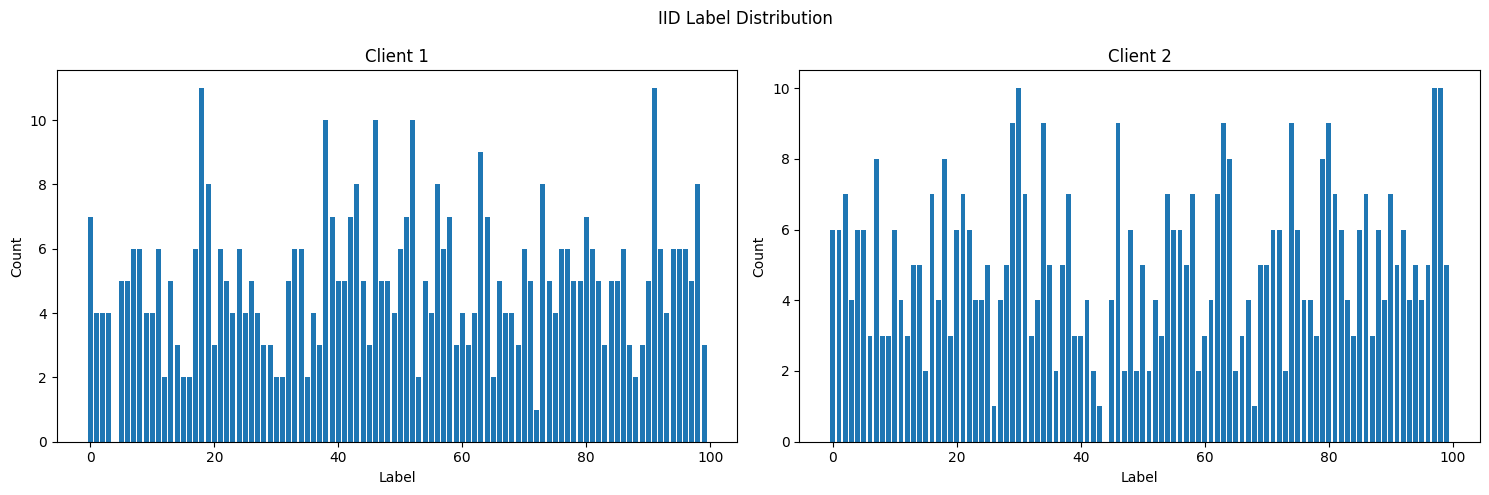

IID Sharding completed. Number of client: 100

=== Non-IID Sharding ===


Creating Non-IID Shards: 100%|██████████| 100/100 [00:00<00:00, 24083.05it/s]


Plot saved as: Non-IID_Label_Distribution.pdf


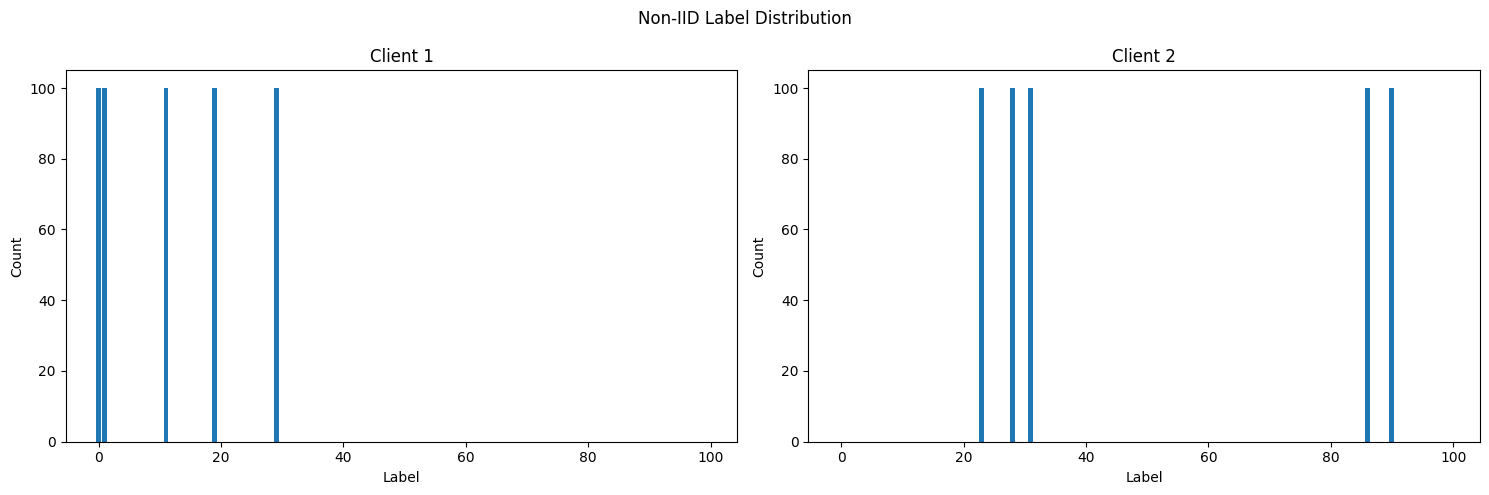

Non-IID Sharding completed. Number of client: 100


In [1]:
import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

class DatasetSharder:
    def __init__(self, config, trainset):
        self.num_clients = config.get('K')
        self.shard_type = config.get('shard_type')
        self.num_labels = config.get('Nc', None)
        self.dataset = trainset
        self._validate_configuration()

    def _validate_configuration(self):
        dataset_size = len(self.dataset)
        total_classes = len(set([label for _, label in self.dataset]))

        if self.num_clients > dataset_size:
            raise ValueError(f"Number of clients ({self.num_clients}) exceeds dataset size ({dataset_size}).")

        if self.shard_type == 'non_iid':
            if self.num_labels is None:
                raise ValueError("Number of labels per client ('Nc') must be specified for Non-IID sharding.")
            if self.num_labels > total_classes:
                raise ValueError(f"Number of labels per client ({self.num_labels}) "
                                 f"exceeds total number of classes ({total_classes}).")

    def create_iid_shards(self):
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.num_clients

        lengths = [samples_per_client] * self.num_clients
        remainder = dataset_size - samples_per_client * self.num_clients
        for i in range(remainder):
            lengths[i] += 1

        return random_split(self.dataset, lengths)

    def create_non_iid_shards(self):
        # Step 1: Group dataset indices by label
        label_to_indices = defaultdict(list)
        for idx, (_, label) in enumerate(self.dataset):
            label_to_indices[label].append(idx)

        # Step 2: Shuffle the indices for each label
        for label in label_to_indices:
            shuffle(label_to_indices[label])

        # Step 3: Initialize shards
        shards = [[] for _ in range(self.num_clients)]

        # Step 4: Calculate samples per client
        total_samples = len(self.dataset)
        samples_per_client = total_samples // self.num_clients

        # Step 5: Prepare list of all labels
        all_labels = list(label_to_indices.keys())

        # Create shards
        for client_id in tqdm(range(self.num_clients), desc="Creating Non-IID Shards"):
            start_label_idx = client_id * self.num_labels
            end_label_idx = (client_id + 1) * self.num_labels
            client_labels = all_labels[start_label_idx:end_label_idx]

            client_indices = []

            for label in client_labels:
                indices = label_to_indices[label]
                num_samples_per_label = samples_per_client // self.num_labels
                client_indices.extend(indices[:num_samples_per_label])
                label_to_indices[label] = indices[num_samples_per_label:]

            client_indices = client_indices[:samples_per_client]
            shards[client_id] = client_indices

        return [Subset(self.dataset, indices) for indices in shards]

    def shard_dataset(self):
        if self.shard_type == 'iid':
            return self.create_iid_shards()
        elif self.shard_type == 'non_iid':
            return self.create_non_iid_shards()
        else:
            raise ValueError(f"Unsupported shard_type: {self.shard_type}")

def load_cifar100():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
    ])

    trainset = datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    return trainset

def plot_label_distribution(client_datasets, num_classes=100, title="Label Distribution", max_clients_to_plot=2):
    num_clients_to_plot = min(len(client_datasets), max_clients_to_plot)

    client_labels = []
    for dataset in client_datasets[:num_clients_to_plot]:
        labels = [label for _, label in dataset]
        client_labels.append(labels)

    label_counts = []
    for labels in client_labels:
        counts = [labels.count(i) for i in range(num_classes)]
        label_counts.append(counts)

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(num_clients_to_plot):
        axes[i].bar(range(num_classes), label_counts[i])
        axes[i].set_title(f'Client {i+1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')

    plt.suptitle(title)
    plt.tight_layout()

    # Save the plots
    save_path = f"{title.replace(' ', '_')}.pdf"  # Save as PDF for LaTeX
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Plot saved as: {save_path}")

    plt.show()

def main():
    # Load the CIFAR-100 training dataset
    trainset = load_cifar100()

    # Create configurations for both Non-IID and IID
    configs = {
        'iid': {
            'K': 100,
            'shard_type': 'iid'
        },
        'non_iid': {
            'K': 100,
            'shard_type': 'non_iid',
            'Nc': 5
        }
    }

    # IID Sharding
    print("\n=== IID Sharding ===")
    iid_sharder = DatasetSharder(configs['iid'], trainset)
    iid_client_datasets = iid_sharder.shard_dataset()
    plot_label_distribution(iid_client_datasets, title="IID Label Distribution")
    print(f"IID Sharding completed. Number of client: {len(iid_client_datasets)}\n")

    # Non-IID Sharding
    print("=== Non-IID Sharding ===")
    non_iid_sharder = DatasetSharder(configs['non_iid'], trainset)
    non_iid_client_datasets = non_iid_sharder.shard_dataset()
    plot_label_distribution(non_iid_client_datasets, title="Non-IID Label Distribution")
    print(f"Non-IID Sharding completed. Number of client: {len(non_iid_client_datasets)}")

if __name__ == "__main__":
    main()